In [1]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as smapi
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import ydata_profiling as pp
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
infosys=pd.read_csv("INFY.csv",index_col='Date',parse_dates=['Date'],date_parser=date_parser).fillna(0)

In [3]:
#ht=pp.ProfileReport(infosys)
#ht.to_file("infosys.html")

In [4]:
infosys.head(20)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,7.87,8.02,7.76,7.78,7.285390,15617300
2020-04-02,7.80,8.02,7.74,7.91,7.407125,7323600
2020-04-03,7.80,7.81,7.46,7.56,7.079377,15539600
2020-04-06,7.86,8.28,7.80,8.25,7.725509,16003400
2020-04-07,8.67,8.77,8.35,8.38,7.847245,15033000
2020-04-08,8.41,8.52,8.19,8.48,7.940888,13721300
2020-04-09,8.55,8.68,8.47,8.52,7.978345,9988000
2020-04-13,8.50,8.55,8.32,8.50,7.959616,5684500
2020-04-14,8.59,8.74,8.48,8.67,8.118809,7582100


In [5]:
infosys.shape

(714, 6)

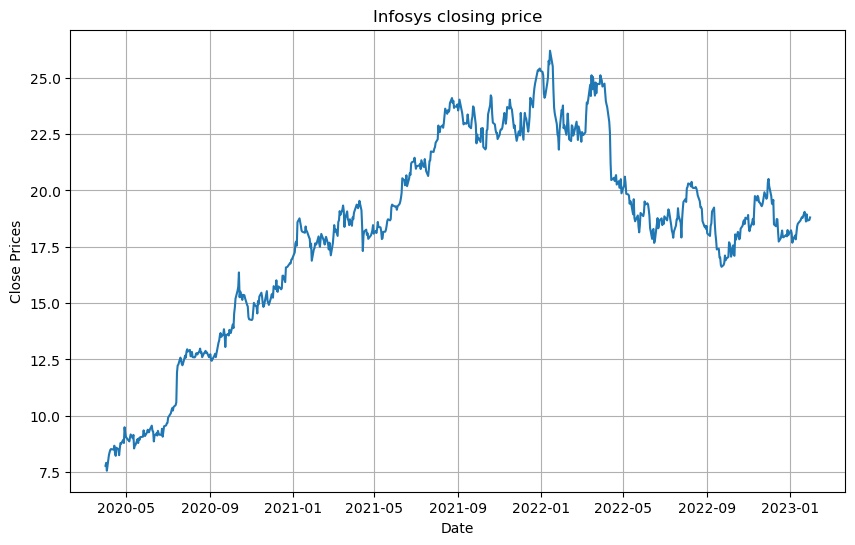

In [6]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(infosys['Close'])
plt.title('Infosys closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

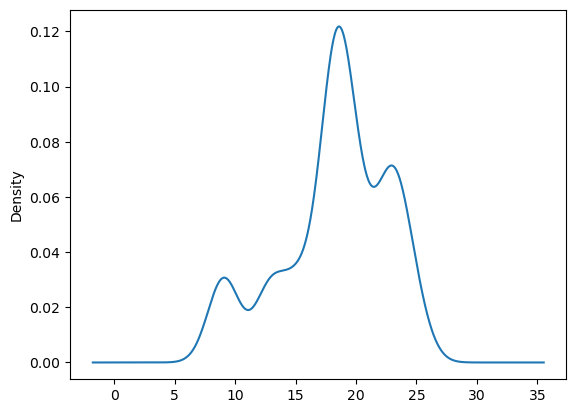

In [7]:
df_close = infosys['Close']
df_close.plot(kind='kde')

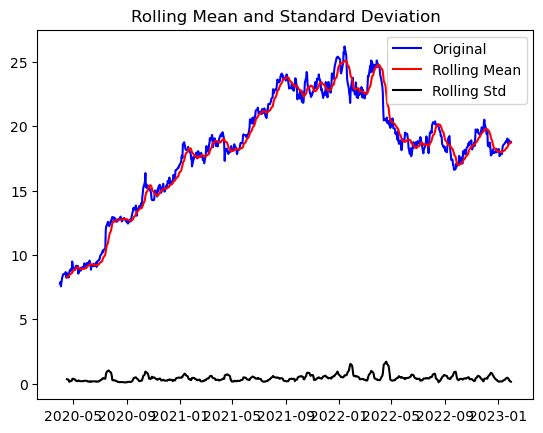

Results of dickey fuller test
Test Statistics                 -2.412554
p-value                          0.138224
No. of lags used                 0.000000
Number of observations used    713.000000
critical value (1%)             -3.439555
critical value (5%)             -2.865602
critical value (10%)            -2.568933
dtype: float64


In [8]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

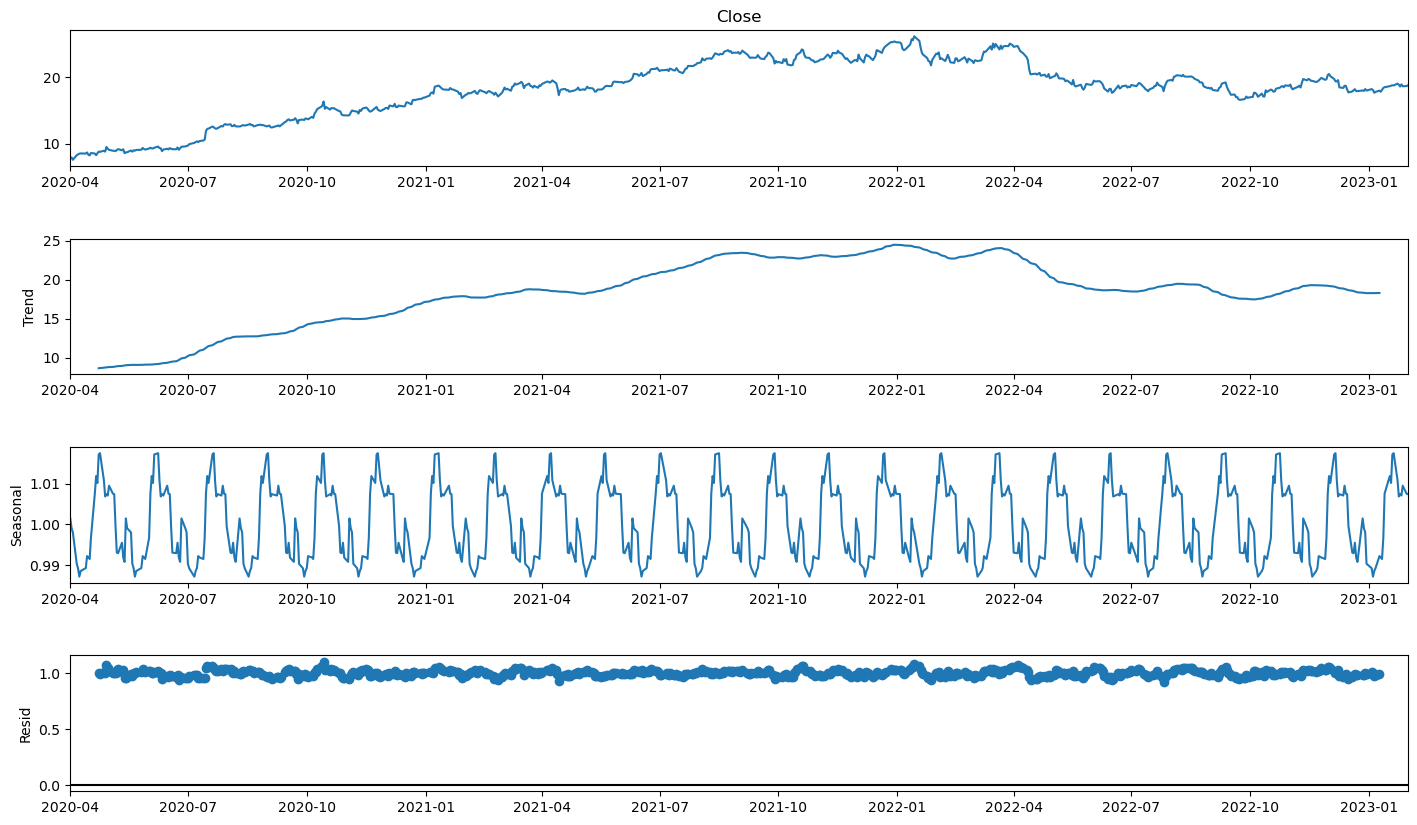

In [9]:
result = seasonal_decompose(df_close, model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


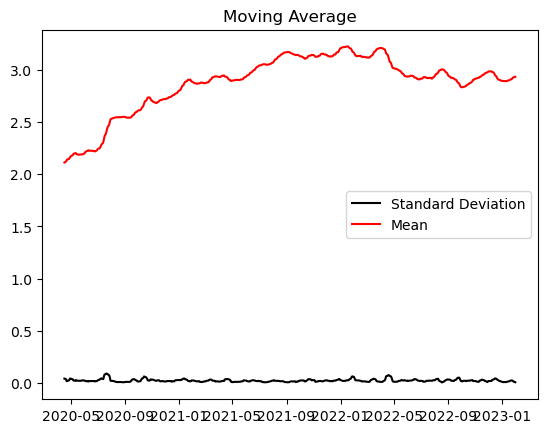

In [10]:
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

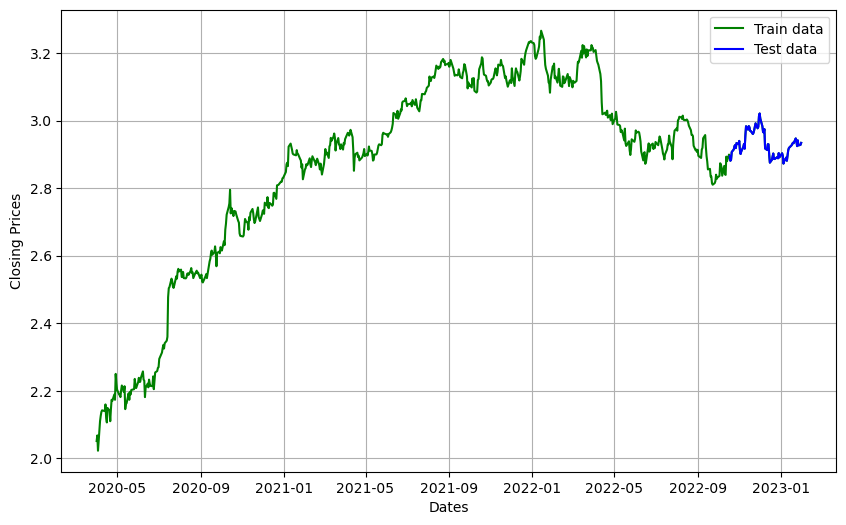

In [11]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [12]:
model = smapi.tsa.arima.ARIMA(train_data, order=(4,2,10))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  639
Model:                ARIMA(4, 2, 10)   Log Likelihood                1621.201
Date:                Fri, 17 Feb 2023   AIC                          -3212.402
Time:                        16:37:47   BIC                          -3145.550
Sample:                             0   HQIC                         -3186.448
                                - 639                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4349      0.860     -1.669      0.095      -3.120       0.251
ar.L2         -0.9238      1.636     -0.565      0.572      -4.130       2.282
ar.L3         -0.2372      1.534     -0.155      0.8

In [13]:
res=result.forecast(72,alpha=0.01).to_frame()
test_data=test_data.to_frame()

In [14]:
from sklearn.metrics import mean_squared_log_error
RMSLE =  np.sqrt(mean_squared_log_error(test_data['Close'].to_numpy(),res['predicted_mean'].to_numpy()))
print('RMSLE:',RMSLE)

RMSLE: 0.016161835164971435


In [15]:
res

,predicted_mean
639,2.896459
640,2.899065
641,2.894905
642,2.894987
643,2.892429
...,...
706,2.860253
707,2.859706
708,2.859158
709,2.858610


In [16]:
test_data

,Close
Date,
2022-10-18,2.894253
2022-10-19,2.880882
2022-10-20,2.884242
2022-10-21,2.906901
2022-10-24,2.914522
...,...
2023-01-25,2.924236
2023-01-26,2.941276
2023-01-27,2.926382


/home/siddhant/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


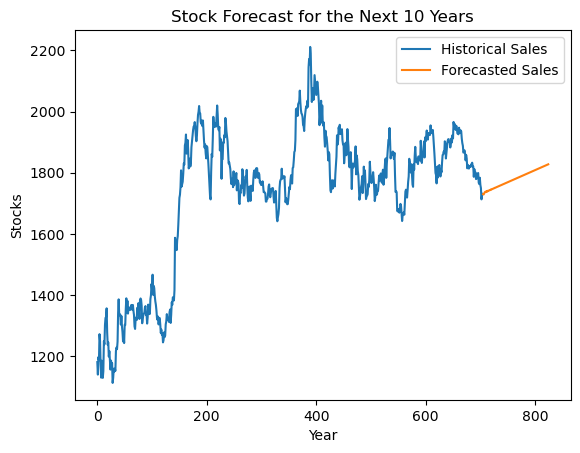

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Read data from INFY.CSV file
data = pd.read_csv('KOTAKBANK.NS.csv')
sales = data['Close']

# Fit ARIMA model
model = ARIMA(sales, order=(4,2,10))
model_fit = model.fit()

# Forecast future sales for the next 10 years
forecast = model_fit.forecast(steps=10*12)

# Plot the forecasted sales
plt.plot(sales)
plt.plot(forecast)
plt.title('Stock Forecast for the Next 10 Years')
plt.xlabel('Year')
plt.ylabel('Stocks')
plt.legend(['Historical Sales', 'Forecasted Sales'])
plt.show()

In [3]:
import pickle
pickle.dump(model_fit,open("kotak.sav","wb"))